# The Hitchiker's Guide to Puerto Rico Exploratory Data Analysis
In this project, we are going to use all the Data Science and Machine Learning skills we have acquired during the course of the last few weeks to build an interactive travel planner for the beautiful island of Puerto Rico. By the end of this project, we will present a working application that cooperates with a visitor to help them build a travel itinerary suitable to their personal preferences.

Before we can start, we need to understand the datasets that we will be utilizing for the implementation of this project. The 3 dataset that we will use are:


1.   elmundo_chunked_es_page1_40years - collection of news articles spanning 40 years
2.   municipalities - information on all 78 municipalities located in Puerto Rico
3.   landmarks - information on important landmarks located in Puerto Rico





## Exploratory Data Analysis
First we mount Google drive to bring the files from the project and analyze them.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt

# to .json
import json
from bs4 import BeautifulSoup
import re
import html

## Checking Dataset Folder Contents
Before we begin working with the datasets, we need to check then and make sure what type of data is contained within them. By now we are used to working with large datasets so we'll apply the same techniques used throughout the bootcamp.

In [ ]:
import os

# Define your folder paths
folder_paths = [
    "/content/drive/MyDrive/IronHack_final_project/elmundo_chunked_es_page1_40years",
    "/content/drive/MyDrive/IronHack_final_project/municipalities",
    "/content/drive/MyDrive/IronHack_final_project/landmarks"
]

# Count files in each folder
for folder in folder_paths:
    if os.path.exists(folder):
        file_count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
        print(f"Folder '{folder}' contains {file_count} files.")
    else:
        print(f"Folder '{folder}' does not exist.")


Folder '/content/drive/MyDrive/IronHack_final_project/elmundo_chunked_es_page1_40years' contains 1668 files.
Folder '/content/drive/MyDrive/IronHack_final_project/municipalities' contains 78 files.
Folder '/content/drive/MyDrive/IronHack_final_project/landmarks' contains 574 files.


### Each folder contains:


1.   News article folder contains: 1668 files of text
2.   Municipalities contains: 78 files of raw HTML
3.   Landmarks contains: 574 files of raw HTML

The text files can be processed directly  without issue, however, the raw HTML will need to be preprocessed to extract the useful information from them. We have decided to arrange everything neatly in a .json(JavaScript Object Notation) file for easier and cleaner access. From the raw HTML we need to extract things:

1.   name - of the landmark or municipality
2.   summary - brief description
3.   coordinates - location





# To JSON

### Functions
With these functions we clean the datasets and then turn them into .json format to use later on in the implementation.

In [ ]:
# Function to clean unwanted characters and fix words
def clean_text(text):
    # Remove unwanted characters (e.g., escape sequences like "\xc9")
    text = re.sub(r'\\[xX][0-9A-Fa-f]{2}', '', text)  # Remove escaped Unicode characters
    text = re.sub(r'[\r\n\t]', ' ', text)  # Remove newlines and tabs
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with one
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Function to add missing characters like 'ñ'
def add_missing_characters(text):
    # Mapping of words that might need 'ñ' or other fixes
    replacements = {
        "Aguada": "Aguada",
        "Aasco": "Añasco",
        "Catao": "Cataño",
        "Nio": "Niño",
        "Peuelas": "Peñuelas"
        # Add other common words as needed
    }

    # Replace words based on the mapping
    for wrong_word, correct_word in replacements.items():
        text = re.sub(rf'\b{wrong_word}\b', correct_word, text, flags=re.IGNORECASE)
    return text

# Function to extract coordinates from the HTML content
def extract_coordinates(html_content):
    # Regex pattern to match lat and lon inside "wgCoordinates"
    coordinates_pattern = r'"wgCoordinates":\s*\{\s*"lat":\s*(-?\d+\.\d+),\s*"lon":\s*(-?\d+\.\d+)\s*\}'
    match = re.search(coordinates_pattern, html_content)

    if match:
        # Clean and extract latitude and longitude as float values
        lat = float(match.group(1).strip().replace("\\n", ""))  # Remove any unwanted newline characters
        lon = float(match.group(2).strip().replace("\\n", ""))  # Remove any unwanted newline characters
        return lat, lon

    return None, None

### Municipalities

In [ ]:
# Path to the municipalities folder in Google Drive
municipalities_folder = "/content/drive/MyDrive/IronHack_final_project/municipalities"

# List to store structured data
municipalities_data = []

# Loop through each .txt file in the folder
for filename in os.listdir(municipalities_folder):
    if filename.endswith(".txt"):  # Ensure we only process .txt files
        file_path = os.path.join(municipalities_folder, filename)

        # Read the HTML content
        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()

        # Parse HTML using BeautifulSoup
        soup = BeautifulSoup(html_content, "html.parser")

        # Extract title (or use filename if no title found), and clean it
        title = clean_text(soup.title.string) if soup.title else clean_text(filename.replace(".txt", ""))
        # Remove " - Wikipedia" from the title
        title = title.replace(" - Wikipedia", "")
        title = add_missing_characters(title)  # Add missing characters to the title

        # Extract first 3 paragraphs for description
        paragraphs = [clean_text(p.get_text(strip=True)) for p in soup.find_all("p")][:3]
        paragraphs = [add_missing_characters(p) for p in paragraphs]  # Add missing characters to description

        # Extract coordinates (latitude and longitude) from HTML content
        latitude, longitude = extract_coordinates(html_content)

        # Structure the data
        municipality = {
            "name": title,
            "category": "Municipality",
            "description": paragraphs,
            "coordinates": {
                "latitude": latitude,
                "longitude": longitude
            },
            "source_file": filename
        }

        # Append to the list
        municipalities_data.append(municipality)

# Save structured data as JSON
output_json = "/content/drive/MyDrive/IronHack_final_project/municipalities.json"
with open(output_json, "w", encoding="utf-8") as json_file:
    json.dump(municipalities_data, json_file, indent=4, ensure_ascii=False)

print(f"Municipality data with coordinates saved as {output_json}")

Municipality data with coordinates saved as /content/drive/MyDrive/IronHack_final_project/municipalities.json


### Landmarks

In [ ]:
# Path to the landmarks folder in Google Drive
landmarks_folder = "/content/drive/MyDrive/IronHack_final_project/landmarks"

# List to store structured data
landmarks_data = []

# Loop through each .txt file in the folder
for filename in os.listdir(landmarks_folder):
    if filename.endswith(".txt"):  # Ensure we only process .txt files
        file_path = os.path.join(landmarks_folder, filename)

        # Read the HTML content
        with open(file_path, "r", encoding="utf-8") as file:
            html_content = file.read()

        # Parse HTML using BeautifulSoup
        soup = BeautifulSoup(html_content, "html.parser")

        # Extract title (or use filename if no title found)
        title = soup.title.string if soup.title else filename.replace(".txt", "")
        title = clean_text(title)  # Clean the title text

        # Extract first 3 paragraphs for description
        paragraphs = [p.get_text(strip=True) for p in soup.find_all("p")][:3]
        paragraphs = [clean_text(paragraph) for paragraph in paragraphs]  # Clean description paragraphs

        # Extract coordinates (if available)
        lat, lon = extract_coordinates(html_content)
        coordinates = {"latitude": lat, "longitude": lon} if lat and lon else None

        # Find the municipality (look for it in the text)
        municipality = None
        if "municipality" in html_content.lower():
            municipality_match = re.search(r"Municipality of\s+([A-Za-z\s]+)", html_content)
            if municipality_match:
                municipality = clean_text(municipality_match.group(1))  # Clean municipality text

        # Structure the data
        landmark = {
            "name": title,
            "category": "Landmark",
            "description": paragraphs,
            "coordinates": coordinates,
            "municipality": municipality,
            "source_file": filename
        }

        # Append to the list
        landmarks_data.append(landmark)

# Save structured data as JSON
output_json = "/content/drive/MyDrive/IronHack_final_project/landmarks.json"
with open(output_json, "w", encoding="utf-8") as json_file:
    json.dump(landmarks_data, json_file, indent=4, ensure_ascii=False)

print(f"Landmark data saved as {output_json}")

Landmark data saved as /content/drive/MyDrive/IronHack_final_project/landmarks.json


## News

In [ ]:
# Navigate to the correct folder
data_dir = "/content/drive/MyDrive/IronHack_final_project/elmundo_chunked_es_page1_40years"
files = os.listdir(data_dir)

print(f"Total files: {len(files)}")
print("Sample files:", files[:5])  # Preview first 5 files
file_sizes = {file: os.path.getsize(os.path.join(data_dir, file)) for file in files}
print(f"Average file size: {sum(file_sizes.values()) / len(file_sizes):.2f} bytes")
print("Smallest files:", sorted(file_sizes.items(), key=lambda x: x[1])[:5])
print("Largest files:", sorted(file_sizes.items(), key=lambda x: x[1], reverse=True)[:5])

Total files: 1668
Sample files: ['19320430_1.txt', '19320305_1.txt', '19311226_1.txt', '19301206_1.txt', '19320123_1.txt']
Average file size: 19467.90 bytes
Smallest files: [('19380101_1.txt', 9), ('19410104_1.txt', 9), ('19280901_1.txt', 6673), ('19351221_1.txt', 7570), ('19360125_1.txt', 7782)]
Largest files: [('19470802_1.txt', 37101), ('19471004_1.txt', 36966), ('19461221_1.txt', 36070), ('19470524_1.txt', 35724), ('19471206_1.txt', 35615)]


### Sampling Data from the News Articles

In [ ]:
def read_text_file(file_path, num_lines=15):
    with open(file_path, "r", encoding="utf-8") as f:
        return "\n".join([next(f) for _ in range(num_lines)])

sample_file = os.path.join(data_dir, files[0])
print(f"Contents of {files[0]}:\n", read_text_file(sample_file))

Contents of 19320430_1.txt:
 elmBndo

1 SPáginasJctvs

J

DIARIO DE LA MAÑANA

AÑO XIV. | SAN JUAN, PUERTO RICO.

*£!* <Us £ ibut 2‘ 1 u f^ er No. 801 authorized by the Act of October 6, 1917, on file at the Poet Office at tbe Prftsl( lent A. S. Burleson, Postmaster General. Entered as second class matter. febr uary 21, 1919 at the Post Office at San Juan. P. R. (United States of America) under the Act of march 3, 1879.

¡ SABADO 30 DE ABRIL DE 1932. I NUMERO 4647.

PROYECTOS DE LEY Y RESOLUCIONES FIRMADOS M

El gobernador Beverley, momento» ante» de embarcar, firmó los sígnente» proyecto» d» ley y reso- * luclone»:P. del S. 146, titulado: "Ley creando un fondo permanente de emergencia; disponiendo lo necesario para su aplicación, y para otro» fines.'’ P. de la O. 252, titulado: “Ley para enmendar la Sección 1 de la Ley Núm. 17 aprobada el 27 de mayo de 1919 titulada ‘Ley para impedir la Introducción en Puerto Rico de enfermedades de plantas e insectos y de plagas’, y para otros fines.

In [ ]:
file_lengths = []

for file in files:
    with open(os.path.join(data_dir, file), "r", encoding="utf-8") as f:
        text = f.read()
        file_lengths.append(len(text.split()))  # Count words

print(f"Average words per file: {np.mean(file_lengths):.2f}")
print(f"Min words: {np.min(file_lengths)}, Max words: {np.max(file_lengths)}")

Average words per file: 3227.00
Min words: 2, Max words: 6177


### Word Count plot
To vicualize the amount of words in each file of the dataset and have a better understanding of the average file length.

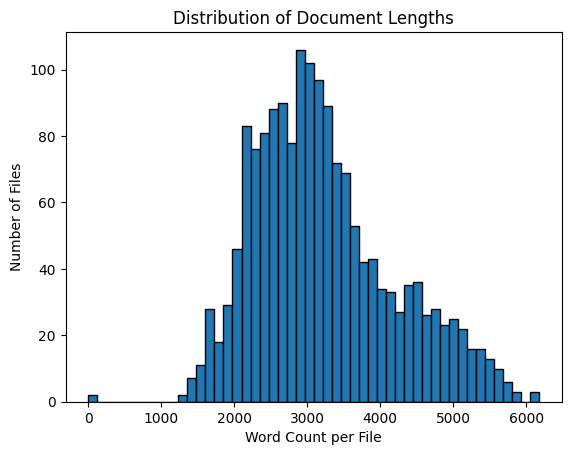

In [ ]:
plt.hist(file_lengths, bins=50, edgecolor="black")
plt.xlabel("Word Count per File")
plt.ylabel("Number of Files")
plt.title("Distribution of Document Lengths")
plt.show()